<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/K_E_AI_AGENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

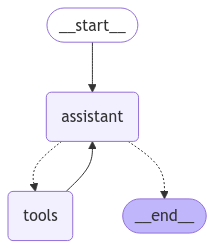

In [4]:
# Install necessary packages
!pip install --quiet -U langchain_google_genai langchain_core langgraph

from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
LANGCHAIN_API_KEY = userdata.get('langchain')

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()


# Initialize the language model (Gemini)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

# Tools: Define functions for electricity department tasks

def check_power_outage_area(pincode: str) -> str:
    """
    Check if there is a power outage in the user's area based on pincode.
    Returns a message with the status and an estimated time of restoration if outage is present.
    """
    # Mocked data for demonstration
    outage_areas = {
        "110001": {"status": "outage", "restore_time": "2 hours"},
        "110002": {"status": "no outage", "restore_time": None},
    }

    info = outage_areas.get(pincode, {"status": "no info", "restore_time": None})
    if info["status"] == "outage":
        return f"There is a power outage in your area. Estimated restoration time is {info['restore_time']}."
    elif info["status"] == "no outage":
        return "There is currently no recorded outage in your area."
    else:
        return "No information available for your area. Please contact customer support."

def get_bill_info(consumer_number: str) -> str:
    """
    Returns billing information based on consumer number.
    """
    # Mocked data
    bills = {
        "123456": "Your current outstanding amount is Rs. 500, due by the end of this month.",
        "987654": "Your account is fully paid. No dues currently."
    }

    return bills.get(consumer_number, "No billing information found for this consumer number.")

def complaint_status(complaint_id: str) -> str:
    """
    Check complaint status based on complaint_id.
    """
    # Mocked data
    complaints = {
        "C-1001": "Your complaint is being processed. Estimated resolution in 24 hours.",
        "C-1002": "Your complaint has been resolved. Please check your email for details."
    }
    return complaints.get(complaint_id, "No information found for this complaint ID.")

# Prepare tools
tools = [
    check_power_outage_area,
    get_bill_info,
    complaint_status
]

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

# System message to define the AI Assistant role
sys_msg = SystemMessage(content=(
    "You are a knowledgeable assistant for the Electricity Department. Your role is to provide "
    "information about power outages, estimated restoration times, billing queries, and complaint "
    "statuses. Always respond politely and professionally. If you cannot find information, "
    "suggest contacting customer support."
))

# Define the assistant node
def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build the graph
memory = MemorySaver()
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
config1 = {"configurable": {"thread_id": "1"}}


messages = graph.invoke({"messages": [HumanMessage(content="ASSALAMUALYUM I M NAVEED FROM KARACHI")]},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

ASSALAMUALYUM I M NAVEED FROM KARACHI
================================== Ai Message ==================================

Assalamualykum Naveed!  How can I help you today?


In [6]:
messages = graph.invoke({"messages": [HumanMessage(content="Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.



In [7]:
messages = graph.invoke({"messages": [HumanMessage(content="MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.



In [8]:
messages = graph.invoke({"messages": [HumanMessage(content="My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.

My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.
I am sorry, I cannot directly access detailed rate information or explain the differences i

In [9]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the status of complaint ID C-1002?")]}, config1)
for m in messages['messages']:
    print(m.content)


ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.

My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.
I am sorry, I cannot directly access detailed rate information or explain the differences i

In [11]:
messages = graph.invoke({"messages": [HumanMessage(content="My area’s pincode is 110001 and the power is out. How long until it comes back?")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.

My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.
I am sorry, I cannot directly access detailed rate information or explain the differences i

In [12]:
messages = graph.invoke({"messages": [HumanMessage(content="I have a complaint with ID C-1002. Can you check its current status?")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.

My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.
I am sorry, I cannot directly access detailed rate information or explain the differences i

In [13]:
messages = graph.invoke({"messages": [HumanMessage(content="My area's pincode is 110001 and voltage is very low, plz check what is actual issue?")]}, config1)
for m in messages['messages']:
    print(m.content)

ASSALAMUALYUM I M NAVEED FROM KARACHI
Assalamualykum Naveed!  How can I help you today?

Light chali gai hai, Mera pincode 110001 hai, wapas kab aayegi?
وعلیکم السلام!  Naveed,  I understand you're experiencing a power outage in the 110001 pincode area.  Let me check the status for you.


There is a power outage in your area. Estimated restoration time is 2 hours.
Naveed, I understand your electricity has gone out.  According to our system, there is a power outage in your area (pincode 110001). The estimated restoration time is within 2 hours.

MY CONSUMER NUMBER IS  123456 . PLZ CHECK STATUS OF MY BILL.

Your current outstanding amount is Rs. 500, due by the end of this month.
Certainly.  Your current outstanding bill is Rs. 500 and is due by the end of the month.

My last month's bill for 201 units was 8,000, but now for 145 units it's 9,000. Check what has increased in rate. Check the tariff.
I am sorry, I cannot directly access detailed rate information or explain the differences i